In [6]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib as mp
import matplotlib.cm as cm

import flopy

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
from scipy import stats

from flopy.utils.sfroutputfile import SfrFile

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

from treeFuncs import trainAndEvaluateModel 
from treeFuncs import metrics
from treeFuncs import plotImportance

from spotpy.objectivefunctions import correlationcoefficient as r

modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws= "D:/mfoutput"

In [7]:
col_names = ['K', 'Low_K_ratio', 'Sy', 'Rech', 'ET_valley', 'ET_rip_ratio', 'Stream_K_ratio','Pumping Rate','Qout']
col_dict = {'K':'Base K', 'Low_K_ratio': 'Confining Layer K (as a ratio to Base K)', 'Sy':'Specific Yield', 'Rech':'Recharge', 'ET_valley':'Valley ET', 'ET_rip_ratio':'Riparian ET (as a ratio of Valley ET)', 'Stream_K_ratio':'Streambed K', 'Pumping Rate':'Pumping Well Discharge Factor'}
#col_names = col_dict.keys

# load dataset

#data = np.loadtxt("mf_notebooks/ModflowSfrWellOutput1000Test11.txt")
data = np.loadtxt("mf_notebooks/ModflowSfrWellOutput1000Test12.txt")
error_list = np.loadtxt("mf_notebooks/ErrorSS_SfrWell1000Test12.txt") #get an index of simulations that were completed successfully in modflow

eidx = np.array(error_list)[:,0].astype(int)
temprange = np.arange(1000)

error_free = np.delete(temprange, eidx, axis=0)

df = pd.DataFrame(data, index=error_free, columns = col_names)
print(df.index.shape)

#Set inputs and targets
X = df[col_names[:-1]] 
Y = df[col_names[-1]] #the last column in the saved csv is the flow at reach 49 - this is for ease of testing - other reaches are brought in later 


(977,)


0
Int64Index([  0,   1,   2,   3,   4,   7,   8,   9,  10,  11,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=942)
0
Int64Index([  0,   1,   2,   3,   4,   7,   8,   9,  10,  11,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=942)
(942, 50)


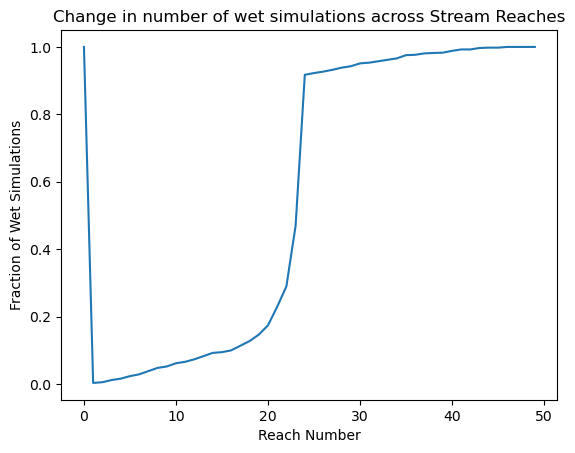

In [8]:
#Getting rid of ensembles with 0 flow - once we set the K and Rech this became less necessary
ReachQdf = pd.read_pickle('outputs/SS_reachQ1000_Test12NoPumping.pkl')#most current?
#ReachQdf = pd.read_pickle('outputs/SS_reachQ1000_Test7.pkl')#original with all varying parameters 

#ReachQdf = pd.DataFrame(ReachQ)

numgrz = [len(ReachQdf[i][ReachQdf[i] > 0].index)/len(ReachQdf.index) for i in range(50)] 
print(numgrz.index(max(numgrz[2:])))


#plt.figure(figsize=(11,3))
plt.plot(numgrz[:])
    
#plt.ylim((0.01,np.max(ReachQdf)+10))
plt.ylabel('Fraction of Wet Simulations')
plt.xlabel('Reach Number')
plt.title('Change in number of wet simulations across Stream Reaches')
plt.margins(0.05)

print(ReachQdf.index)

rn_highest = numgrz.index(max(numgrz[2:])) 
print(rn_highest)#find reach with greatest number of wet ensembles 
ReachQdf = ReachQdf[ReachQdf[rn_highest] > 0]
print(ReachQdf.index)
print(ReachQdf.shape)

np.savetxt("SS_SimListNoPumping.txt", ReachQdf.index.to_list())

## Now for the Modflow Cell Heads

The following cells pull the data from the Modflow output files and save as pkls 

In [9]:
#load in Ibound and find active cells in model

ibound = np.loadtxt('base/ibound_lyr1.txt')            
all_well_loc = np.asarray(np.where(ibound == 1)).T
#print(all_well_loc) #nrow, ncol

In [ ]:
#Get Head data for All active wells

error_free = ReachQdf.index

well_head = np.empty((len(error_free),all_well_loc.shape[0]))
well_error_sim = []
#well_error_num = []
for j, i in enumerate(error_free):
#for j, i in enumerate(df_flow.index):
    modelname = "ScenarioSfrWell1000Test12_"+str(i)
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
    head = headobj.get_alldata(nodata=0)#-9.9998999e+02)
    
    for k in range(all_well_loc.shape[0]):        
        well_head[j][k] = head[0][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])]        #ntime, nlay, nrow, ncol
        #if (well_head[k][j] < 0) or (well_head[k][j] > 200) or np.isnan(well_head[k][j]):
        if (well_head[j][k] > 120 or np.isnan(well_head[j][k]) or well_head[j][k] < 0):
            well_error_sim.append(i)
            
well_head_df = pd.DataFrame(well_head, index = error_free)

#new_zone = ReachQdf.loc[~ReachQdf.index.isin(np.unique(well_error_sim))]
#well_head_df = well_head_df.loc[new_zone.index]

print(len(well_head_df.index))

well_head_df.to_pickle('outputs/heads/WellHead_SS1000Test12.pkl')


In [10]:

#if not pulling new heads
well_head_df= pd.read_pickle('outputs/heads/WellHead_SS1000Test12.pkl')

print(well_head_df.index)
print(ReachQdf.index)

# Since some ensemble members are dropped in the well_head_df
# we change ReachQdf to use the same ensemble members as well_head_df
#ReachQdf = ReachQdf.loc[well_head_df.index]
#ReachAqfdf = ReachAqfdf.loc[well_head_df.index]


Int64Index([  0,   1,   2,   3,   4,   7,   8,   9,  10,  11,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=942)
Int64Index([  0,   1,   2,   3,   4,   7,   8,   9,  10,  11,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=942)


### No Pumping Cells

The following 3 cells pull the data from the modflow files and save the no-pumping heads and streamflows as pickles. The last cell also creates the differnce dataframes for both heads and pumping cells.

In [69]:
#Can skip the next two cells if this has been done already and just read the pkl file
#Pulling head values for runs without pumping
#using the pumping simulations df index to match 
#members = np.loadtxt("mf_notebooks/ModflowSfrWellOutput1000Test12NoPumping.txt")
members = well_head_df.index
well_head = np.empty((len(members),all_well_loc.shape[0]))

for j, i in enumerate(members):
#for j, i in enumerate(df_flow.index):
    modelname = "ScenarioSfrWell1000Test12NoPumping_"+str(int(i))
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
    head = headobj.get_alldata(nodata=0)#-9.9998999e+02)
    
    for k in range(all_well_loc.shape[0]):        
        well_head[j][k] = head[0][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])]        #ntime, nlay, nrow, ncol

No_pumping_well_head_df = pd.DataFrame(well_head, index = members)

#save to pickle
No_pumping_well_head_df.to_pickle('outputs/heads/WellHead_SS1000Test12NoPumping.pkl')


In [70]:
#Pulling out the values from the SFR file for the No Pumping and pumping runs
NoPumpQ = np.ndarray((len(members),50))
PumpQ = np.ndarray((len(members),50))

for j,i in enumerate(members):
    modelnamenp = "/ScenarioSfrWell1000Test12NoPumping_"+str(int(i))
    sfroutnp = SfrFile(modws+'\\'+modelnamenp+'.sfr.out')
    Sfrdfnp = sfroutnp.get_dataframe() 
    NoPumpQ[j] = Sfrdfnp.Qout[:]
      
    modelname = "/ScenarioSfrWell1000Test12_"+str(int(i))
    sfrout = SfrFile(modws+'\\'+modelname+'.sfr.out')
    Sfrdf = sfrout.get_dataframe() 
    PumpQ[j] = Sfrdf.Qout[:]   
    
NoPumpingReachQ = pd.DataFrame(NoPumpQ, index = members)
PumpingReachQ = pd.DataFrame(PumpQ, index = members)

NoPumpingReachQ.to_pickle('outputs/SS_reachQ1000_Test12NoPumping.pkl')
PumpingReachQ.to_pickle('outputs/SS_reachQ1000_Test12.pkl')
#plt.yscale('log') 

,0,1,2,3,4,5,6,7,8,9,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
0,1.728195,1.755302,1.799179,1.852051,1.914673,1.969391,2.035851,2.112366,2.197975,2.291992,...,0.122223,0.124550,0.127373,0.130608,0.134193,0.138107,0.142357,0.146477,0.150261,0.153084
1,0.576530,0.577248,0.578384,0.579567,0.580933,0.581856,0.583008,0.584335,0.585793,0.587326,...,0.496735,0.495659,0.494377,0.492905,0.491257,0.489479,0.487595,0.485626,0.483696,0.482193
2,0.416824,0.419479,0.423775,0.428696,0.434456,0.438164,0.443352,0.449677,0.456993,0.465202,...,0.224541,0.223358,0.222275,0.221268,0.220345,0.219521,0.218857,0.218079,0.217270,0.216621
3,1.319702,1.333885,1.356705,1.383438,1.414978,1.440048,1.471977,1.509209,1.550964,1.596809,...,0.367004,0.365227,0.363625,0.362137,0.360779,0.359627,0.358849,0.357925,0.357033,0.356354
4,2.083427,2.100220,2.127243,2.158409,2.195122,2.223923,2.260551,2.303177,2.350891,2.403152,...,0.828445,0.821922,0.814865,0.807297,0.799347,0.791245,0.783409,0.775215,0.767464,0.761597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.577614,0.581436,0.587578,0.594597,0.602829,0.609161,0.616982,0.626060,0.636215,0.647263,...,0.281418,0.279785,0.277939,0.275894,0.273705,0.271431,0.269127,0.266769,0.264549,0.262848
996,1.045166,1.046211,1.047874,1.049576,1.051514,1.052742,1.054291,1.056061,1.057983,1.060013,...,0.923996,0.922249,0.920143,0.917717,0.915009,0.912056,0.908913,0.905609,0.902390,0.899857
997,1.291351,1.294250,1.298859,1.303841,1.309631,1.313507,1.318718,1.324844,1.331673,1.339104,...,1.024529,1.021614,1.018417,1.014893,1.011086,1.007057,1.003006,0.998634,0.994347,0.991005
998,0.578445,0.586952,0.600677,0.617081,0.636414,0.651657,0.671120,0.693977,0.719810,0.748413,...,0.099106,0.100700,0.102776,0.105225,0.107979,0.111023,0.114365,0.117569,0.120491,0.122650


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,50.8,89.41,126.18,162.80,200.2,239.0,279.8,324.4,...,5170.00,5275.00,5362.00,5434.00,5491.00,5535.00,5566.00,5585.00,5588.00,5588.00
1,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,773.15,821.34,864.21,900.61,929.38,949.35,959.36,958.21,944.30,944.30
2,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,2174.00,2223.00,2265.00,2298.00,2326.00,2347.00,2362.00,2369.00,2365.00,2365.00
3,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,2971.80,3034.20,3086.50,3129.50,3163.90,3190.30,3208.80,3219.40,3219.30,3219.30
4,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,6939.22,7088.00,7211.70,7312.30,7391.31,7449.80,7487.83,7504.71,7487.89,7487.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,3800.70,3885.90,3956.50,4015.00,4060.00,4093.00,4113.00,4120.00,4112.00,4112.00
996,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,190.84,233.03,272.61,307.57,335.85,355.35,363.83,358.47,334.06,334.06
997,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,3386.30,3470.10,3541.60,3599.30,3641.60,3666.70,3671.70,3651.30,3578.80,3578.80
998,0.0,0.0,0.0,27.63,47.60,66.08,84.5,103.5,124.1,148.0,...,1759.00,1795.00,1825.00,1851.00,1871.00,1887.00,1899.00,1906.00,1907.00,1907.00


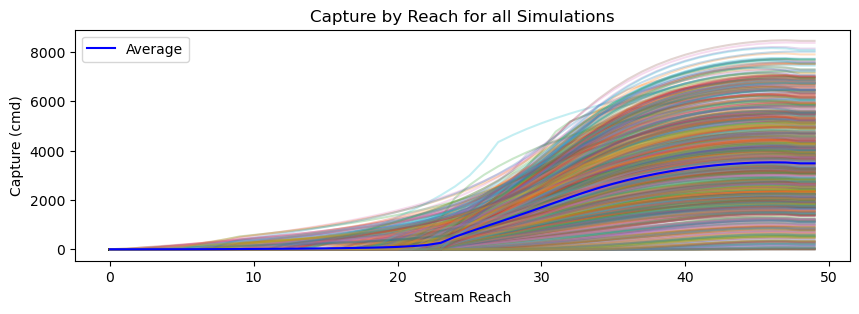

In [11]:
#Calculating the difference in heads from the wells and in the flows from with the well and without
#Read the pkl 
NoPumpingReachQ = pd.read_pickle('outputs/SS_reachQ1000_Test12NoPumping.pkl')
PumpingReachQdf = pd.read_pickle('outputs/SS_reachQ1000_Test12.pkl')

No_pumping_well_head_df = pd.read_pickle('outputs/heads/WellHead_SS1000Test12NoPumping.pkl')
well_head_df= pd.read_pickle('outputs/heads/WellHead_SS1000Test12.pkl')
#members = np.loadtxt("mf_notebooks/ModflowSfrWellOutput1000Test12NoPumping.txt")
members = well_head_df.index
diff_head_df = No_pumping_well_head_df.sub(well_head_df)

#Calculate Capture
diff_reachq_df = NoPumpingReachQ.sub(PumpingReachQdf)

#diff_head_df = diff_head_df.round(0)
display(diff_head_df)
display(diff_reachq_df)

plt.figure(figsize=(10,3))
for i in members:
    diff_reachq_df.loc[i].plot(alpha = 0.25, label=str())
avg = diff_reachq_df.mean().plot(color="blue", label = 'Average')
plt.title("Capture by Reach for all Simulations")
plt.ylabel("Capture (cmd)")
plt.xlabel("Stream Reach")
plt.legend()
plt.show()


# for i in members:
#     PumpingReachQdf.loc[i].plot(color="purple", alpha = 0.5)
#     NoPumpingReachQ.loc[i].plot(color="green", alpha = 0.5)
# #ReachQdf.mean().plot(color="purple")
# plt.title("Capture by Reach for all Simulations")
# plt.ylabel("Capture (cmd)")
# plt.xlabel("Stream Reach")



## Using Heads to predict stream Flow

In [84]:
## Setting up the head inputs - dropping out the downstream most CH boundary and the river cells 

river_well_loc = np.where(all_well_loc[:,0] == 25)
#river_well_loc = np.where((all_well_loc[:,0] > 23) & (all_well_loc[:,0] < 27))

CHBound_loc = np.where(all_well_loc[:,1] > 42)
RechBound_loc = np.where(all_well_loc[:,1] < 10) #
upperRows = np.where(all_well_loc[:,0] > 35)
lowerRows = np.where(all_well_loc[:,0] < 15)
drop_locs= np.concatenate((CHBound_loc,upperRows,lowerRows,RechBound_loc), axis = 1)

#drop_locs= np.concatenate((river_well_loc, CHBound_loc,upperRows,lowerRows,RechBound_loc), axis = 1)
#drop_locs= np.concatenate((river_well_loc, CHBound_loc), axis = 1)
#drop_locs= np.concatenate((river_well_loc, CHBound_loc, RechBound_loc), axis = 1)
drop_locs = CHBound_loc

#For testing out all the cells
drop_locs = [[]]

well_head_noRiv = well_head_df.drop(drop_locs[0], axis = 1)
new_zone_q = PumpingReachQdf.loc[well_head_noRiv.index]

#Below for diff dfs
#new - using regular head values with capture as the target
#well_head_df = well_head_df.loc[members.astype('int')]
well_head_noRiv = diff_head_df.drop(drop_locs[0], axis = 1)

#Capture
new_zone_q = diff_reachq_df.loc[well_head_noRiv.index]



#need to set the column headers as strings otherwise it loses track of them :?
well_head_noRiv.columns = well_head_noRiv.columns.astype(str)

well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])
print(well_head_noRiv.shape)


#Normalizing inputs (?) - not currently using 
# norm_well_df = (well_head_noRiv - np.min(well_head_noRiv.min().values))
# norm_well_df = norm_well_df / np.max(well_head_noRiv.max().values)
# norm_well_df.columns = norm_well_df.columns.astype(str)

# norm_q_df = (new_zone_q - np.min(new_zone_q.min().values))
# norm_q_df = norm_q_df/ np.max(new_zone_q.max().values)

# display(well_head_noRiv)
# display(norm_well_df)
# display(norm_q_df)

pd.set_option("display.max_rows", 6)
pd.set_option("display.max_columns", 6)
pd.options.display.float_format = '{:,.2f}'.format
display(well_head_noRiv)
display(new_zone_q.iloc[:,32:34])

(942, 2012)


,0,1,2,...,2009,2010,2011
0,1.73,1.76,1.80,...,0.15,0.15,0.15
1,0.58,0.58,0.58,...,0.49,0.48,0.48
2,0.42,0.42,0.42,...,0.22,0.22,0.22
...,...,...,...,...,...,...,...
997,1.29,1.29,1.30,...,1.00,0.99,0.99
998,0.58,0.59,0.60,...,0.12,0.12,0.12
999,0.29,0.29,0.30,...,0.13,0.13,0.13


,32,33
0,"3,421.00","3,735.00"
1,316.98,372.74
2,"1,468.20","1,584.90"
...,...,...
997,"2,364.40","2,523.20"
998,"1,203.00","1,299.00"
999,"1,315.60","1,447.00"


### Plotting out Heads
The next couple of cells calculates the spatial statistics including standard deviation, mean, pearson's correaltion for the hydraulic head values. It also computs spearnmans'rank correlation for the feature-to-target correaltions plot.

In [75]:
from treeFuncs import wellmesh_correlation
dist = 2

#corrmatrix = well_head_df.corr()
#neighbor_corr_avg, neighbor_corr_min = wellmesh_correlation(all_well_loc,well_head_df, dist)

#Below for diff_head_df
neighbor_corr_avg, neighbor_corr_min = wellmesh_correlation(all_well_loc,diff_head_df, dist)
corrmatrix = diff_head_df.corr()

well num, well col, well row 

2011 48 18


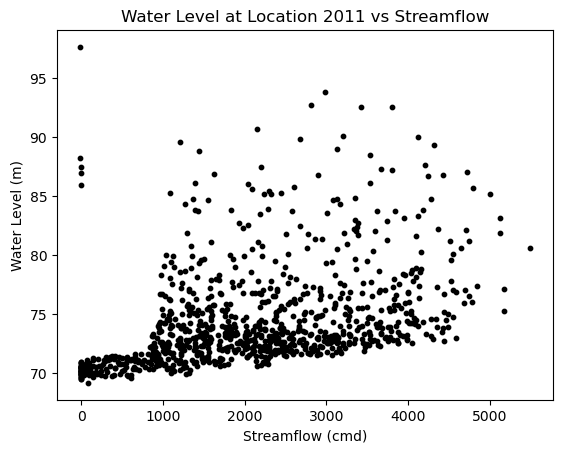

C:\Users\davem\AppData\Local\Temp\ipykernel_7620\3248901786.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=30)


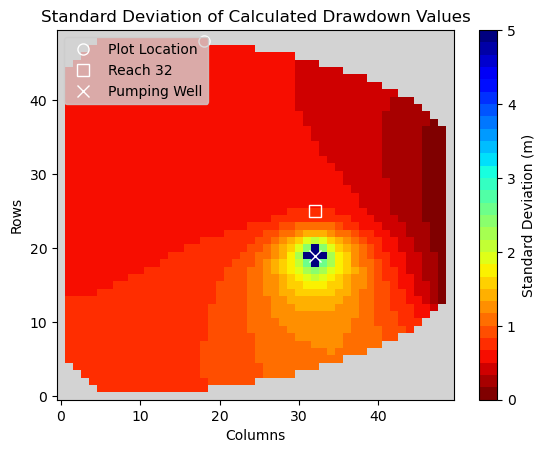

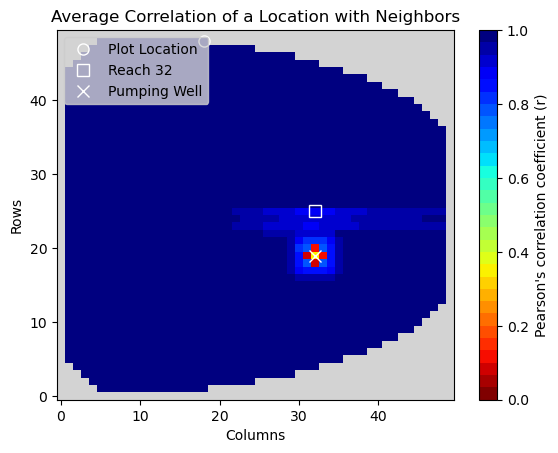

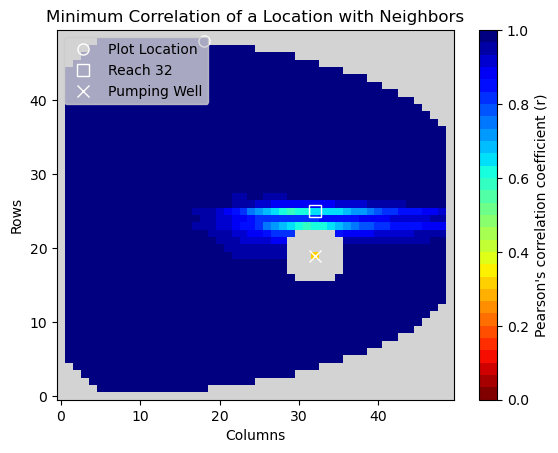

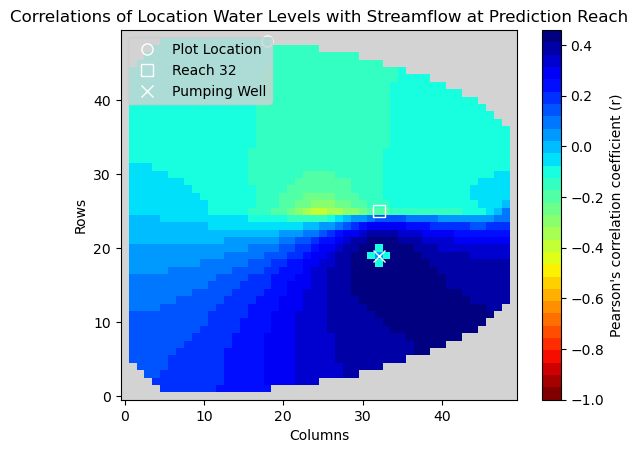

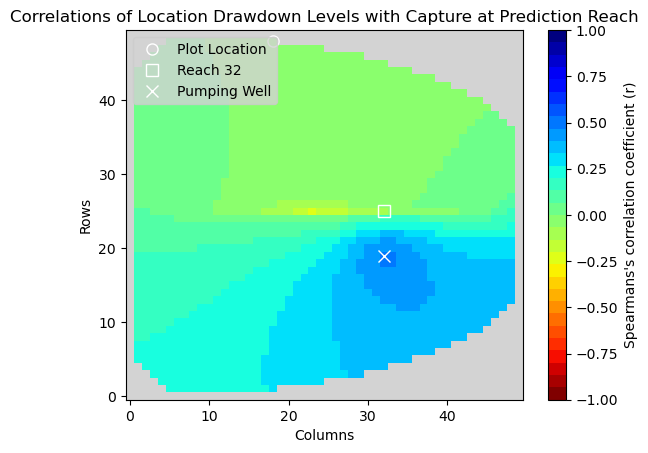

In [76]:
#wn = 844
wn=2011
print("well num, well col, well row \n")
print(wn,int(all_well_loc[wn][0]), int(all_well_loc[wn][1]))

#plt.scatter(range(len(well_head_df[wn].index)),well_head_df[wn].sort_values(), s = 10, c='k')
plt.scatter(new_zone_q[32],well_head_df[wn], s = 10, c='k')
#plt.ylim((0,25))
plt.xlabel('Streamflow (cmd)')
plt.ylabel('Water Level (m)')
plt.title("Water Level at Location 2011 vs Streamflow")# All Simulations \n at Row: " +str(all_well_loc[wn][0])+ " Col: " + str(all_well_loc[wn][1]))
plt.show()

# wn = 1100
# print("well num, well col, well row \n")
# print(wn,int(all_well_loc[wn][0]), int(all_well_loc[wn][1]))

# plt.scatter(range(len(diff_head_df[wn].index)),diff_head_df[wn].sort_values(), s = 10, c='k')
# plt.xlabel('Sorted Simulations')
# plt.ylabel('Hydraulic Head (m)')
# plt.title("Location Head Values across All Steady State Simulations \n at Row: " +str(all_well_loc[wn][0])+ " Col: " + str(all_well_loc[wn][1]))


ztop = np.genfromtxt('base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)


kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

wellmesh = np.ndarray((50,50))
wellmesh[:][:] = -1e30

wellmesh2 = wellmesh.copy()
mesh_feat_to_target = wellmesh.copy()
spearmans_feat_to_target = wellmesh.copy()
p_value_feat_to_target = wellmesh.copy()
wellmesh_corr = wellmesh.copy()
minmesh = wellmesh.copy()
wellmesh_capHg = wellmesh.copy()
wellmesh_capDir = wellmesh.copy()

#Reach number for feature to target correlation
rn = 32

#well_head_df[1060].plot()
#print(int(all_well_loc[wn, 0]),int(all_well_loc[wn, 1]))
for i in range(all_well_loc.shape[0]):
    
    wellmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = well_head_df[i].std()    
    rho, p = stats.spearmanr(new_zone_q[rn],well_head_df[i]) 
    mesh_feat_to_target[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = r(new_zone_q[rn],well_head_df[i])
    wellmesh2[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = well_head_df[i].mean() #- ztop[int(all_well_loc[i, 0]),int(all_well_loc[i, 1])]
    
   # Diff Heads
    rho, p = stats.spearmanr(new_zone_q[rn],diff_head_df[i])
    wellmesh2[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = diff_head_df[i].mean() 
    wellmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = diff_head_df[i].std()
    mesh_feat_to_target[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = r(new_zone_q[rn],diff_head_df[i])
    
    wellmesh_corr[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = corrmatrix[i].mean()
    minmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = corrmatrix[i].min()
    spearmans_feat_to_target[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = rho
    
np.savetxt("CorrDrawCap.csv",spearmans_feat_to_target)

cmap2 = cm.get_cmap("jet_r",lut=30)
cmap2.set_under("lightgray")
river = np.ndarray((48,))
river[:] = 25

#plt.figure(figsize=(8,6))
def headPlot(wellmesh,rn,cmap2,colorbarlabel,title,vmax=None,vmin=-1):
    
    reach_label = "Reach " + str(rn)

    plt.pcolormesh(KK,GG,wellmesh,cmap = cmap2, vmin = vmin,vmax=vmax,shading='nearest')
    plt.colorbar(label = colorbarlabel)
    plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="w", mfc='none', linestyle = "None", label="Plot Location")
    #plt.plot(range(1,49),river, color="lightblue",label='River')
    plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
    plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
    plt.legend(facecolor='lightgray', loc='upper left')
    plt.xlabel('Columns')
    plt.ylabel('Rows')

    plt.title(title)

    plt.show()
    return

title = 'Standard Deviation of Calculated Drawdown Values'
colorbarlabel = 'Standard Deviation (m)'
headPlot(wellmesh,rn,cmap2,colorbarlabel,title,vmax=5,vmin = 0)
#plt.figure(figsize=(8,6))

# title = 'Average head across all Simulations'
# colorbarlabel = 'Head (m)'
# headPlot(wellmesh2,rn,cmap2,colorbarlabel,title)

# title = 'Average Correlation of a Location with all other Locations'
# colorbarlabel = 'Pearson\'s correlation coefficient (r)'
# headPlot(wellmesh_corr,rn,cmap2,colorbarlabel,title)

title = 'Average Correlation of a Location with Neighbors'
colorbarlabel = 'Pearson\'s correlation coefficient (r)'
headPlot(neighbor_corr_avg,rn,cmap2,colorbarlabel,title,vmin=0.0,vmax=1)

title = 'Minimum Correlation of a Location with Neighbors'
colorbarlabel = 'Pearson\'s correlation coefficient (r)'
headPlot(neighbor_corr_min,rn,cmap2,colorbarlabel,title,vmin=0.0,vmax=1)

title = 'Correlations of Location Water Levels with Streamflow at Prediction Reach'
colorbarlabel = 'Pearson\'s correlation coefficient (r)'
headPlot(mesh_feat_to_target,rn,cmap2,colorbarlabel,title)

title = 'Correlations of Location Drawdown Levels with Capture at Prediction Reach'
colorbarlabel = 'Spearmans\'s correlation coefficient (r)'
headPlot(spearmans_feat_to_target,rn,cmap2,colorbarlabel,title,vmax=1,vmin=-1)


## Tree using Wells to predict Qout

In [14]:
#Best pars from Hyperparmeter Tuning notbook saved here as a dictionary
random_state = 29

#DIFF best pars 

#head and streamflow hyperparameters
best_pars_dt = {'splitter': 'best','max_features': 1.0,'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 25, 'max_leaf_nodes': 52, 'max_depth': 6, 'criterion': 'friedman_mse'}


Shape of Input Samples: (942, 2012)
Shape of Output Targets: (942,)
Total time: 1.5095996856689453


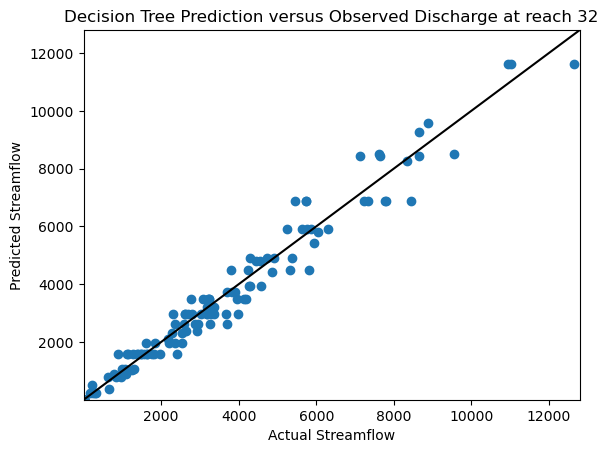

bias       -0.937014
rmse      410.567753
r           0.988626
nse         0.977204
lognse      0.996691
kge         0.985255
dtype: float64


In [15]:
# Split dataset into training set and test set, default here is 30% test
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel
from treeFuncs import metrics

t0 = time.time()
n = 1

rn = 32
random_state = 29

imp_df, metrics_df, impurity_list, Tree, y_test, y_pred_dt = trainAndEvaluateModel(DecisionTreeRegressor, well_head_noRiv, new_zone_q[rn], best_pars_dt, 0.2, n, random_state)  

print('Total time: ' + str(time.time()-t0))

plt.figure()
plt.scatter(y_test, y_pred_dt)

outmax = np.max(y_pred_dt) *1.1
outmin = np.min(y_pred_dt) *0.75

plt.plot([outmin, outmax], [outmin, outmax], color='k', linestyle='-')

lim_tup = (outmin,outmax)
plt.ylim(lim_tup)
plt.xlim(lim_tup)

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Decision Tree Prediction versus Observed Discharge at reach " + str(rn)
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

print(metrics_df.mean())

       bias        rmse         r       nse    lognse       kge
0 -0.937014  410.567753  0.988626  0.977204  0.996691  0.985255


1052    0.885405
1099    0.087346
1235    0.005800
1202    0.005363
1457    0.002780
748     0.001427
749     0.001065
Name: 0, dtype: float64

['0' '1' '2' ... '2009' '2010' '2011']
[0.8854054287387796, 0.08734577030509827, 0.005799521897146867]
[1052, 1099, 1235, 1202, 1457, 748, 749]


,0,1
1052,25,47
1099,26,46
1235,29,38
1202,29,5
1457,34,20
748,19,31
749,19,32


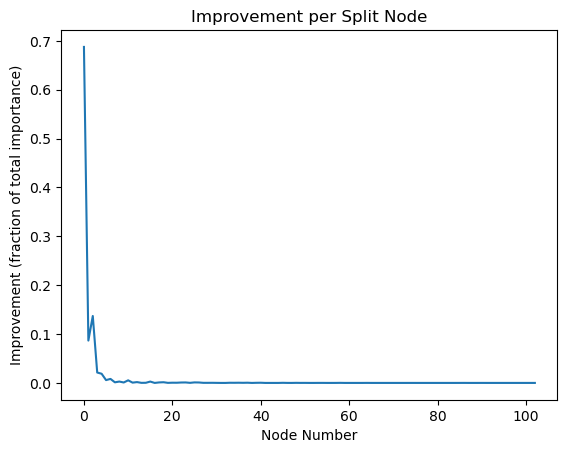

In [16]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import evalTree


print(metrics_df)
#tree.plot_tree(Tree)
treeimp = pd.DataFrame(Tree.feature_importances_, index = Tree.feature_names_in_)
#display(treeimp)
top = treeimp[0].nlargest(7)
display(top)
print(Tree.feature_names_in_)
print(sorted(Tree.feature_importances_, reverse=True)[:3])
from treeFuncs import quickEvalTree
imp_improv = quickEvalTree(Tree)
n_nodes = Tree.tree_.node_count
# for i in range(n_nodes):
#     print(str(i) + ': ' +str(Tree.tree_.impurity[i]))
plt.plot(imp_improv)
plt.title('Improvement per Split Node')
plt.ylabel('Improvement (fraction of total importance)')
plt.xlabel('Node Number')
#help(tree._tree.Tree)
topList = [i for i in top.index.astype(int)]
print(topList)
display(well_loc_df.loc[topList])

[Text(0.5, 0.8333333333333334, 'node #0\n(25, 47) <= 68.77\nfriedman_mse = 9176320.73\nsamples = 100.0%\nvalue = 2500.88'),
 Text(0.25, 0.5, 'node #1\n(26, 46) <= 68.85\nfriedman_mse = 1382295.22\nsamples = 71.7%\nvalue = 923.15'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'node #2\n(25, 47) <= 68.82\nfriedman_mse = 6626159.7\nsamples = 28.3%\nvalue = 6500.75'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

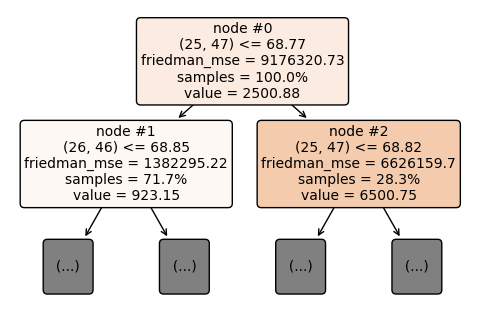

In [17]:
#evalTree(Tree)
plt.figure(figsize=((6,4)))
featurelocs = [tuple(i) for i in well_loc_df.loc[Tree.feature_names_in_.astype(int)].to_numpy()] #well_loc_df.loc[topList].to_numpy()]
#print(featurenames)
tree.plot_tree(Tree, max_depth=1, filled=True, proportion=True, fontsize=10, precision=2,rounded=True,node_ids=True,feature_names=featurelocs)

In [28]:
#Save the importance DF for later
#HeadQ - waterlevels and flow
#HeadCap - water levels and capture
#DrawCap - Drawdown levels and capture
imp_df.to_pickle('outputs/importance/SSTest12DrawCap_DT_Impdf.pkl')

Shape of Input Samples: (942, 2012)
Shape of Output Targets: (942,)
Total time: 14.695958375930786
Fraction of wet simulations: 0.9522292993630573
bias       -4.377394
rmse      944.754510
r           0.695042
nse         0.477633
lognse      0.349732
kge         0.581235
dtype: float64


Text(0.5, 1.0, 'Example Random Decision Tree Regression for Q at reach 32')

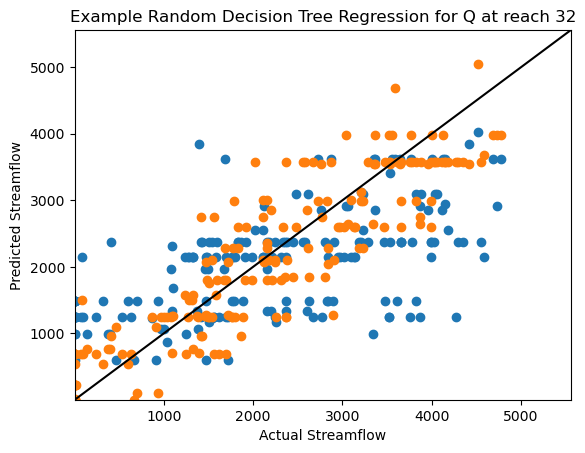

In [29]:
# RANDOM Tree 
# Split dataset into training set and test set, default here is 30% test
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel

t0 = time.time()
n = 100

#Splitter is random and max features is set to 1, note that 1.0 is all in the new Sklearn so this is a little confusing
#lastest and greatest - plus splitter setting to best
#Best Pars
#best_pars_dt_rand = {'splitter': 'best','max_features': 1,'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 5, 'max_leaf_nodes': None, 'max_depth': 4, 'criterion': 'squared_error'}
best_pars_dt_rand = {'splitter': 'best','max_features': 1,'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 25, 'max_leaf_nodes': 52, 'max_depth': 6, 'criterion': 'friedman_mse'}

#imp_df_rand, metrics_df_rand, rand_impurity_list, randTree, y_test, y_pred = trainAndEvaluateModel(ExtraTreeRegressor, norm_well_df, norm_q_df[rn], best_pars_dt_rand, 0.2, n, random_state)  

imp_df_rand, metrics_df_rand, rand_impurity_list, randTree, y_test, y_pred_rft = trainAndEvaluateModel(ExtraTreeRegressor, well_head_noRiv, new_zone_q[rn], best_pars_dt_rand, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_rand.mean())
plt.figure()
plt.scatter(y_test, y_pred_rft, label='RFT')
plt.scatter(y_test, y_pred_dt, label='DT')

plt.plot([outmin, outmax], [outmin, outmax], color='k', linestyle='-')

lim_tup = (outmin,outmax)
plt.ylim(lim_tup)
plt.xlim(lim_tup)

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Example Random Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)

In [30]:
#Save the importance DF for later
#HeadQ
#HeadCap
#DrawCap
imp_df_rand.to_pickle('outputs/importance/SSTest12DrawCap_RFT_Impdf.pkl')

C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("Blues")#,lut=20)
C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("Blues")#,lut=20)


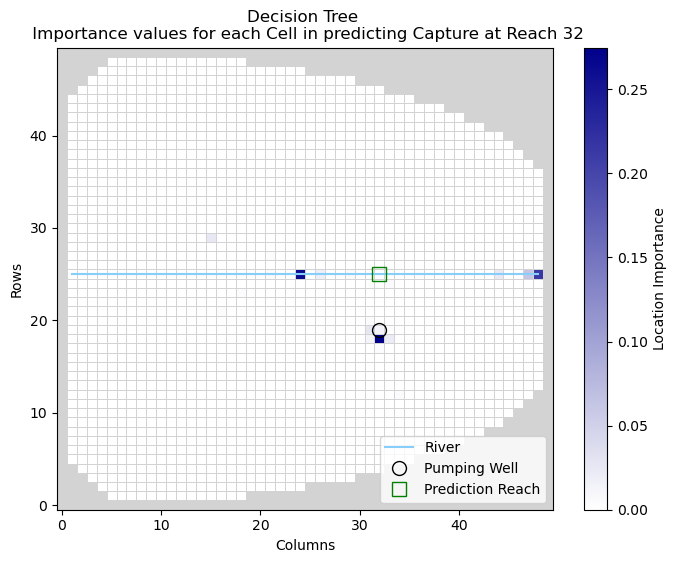

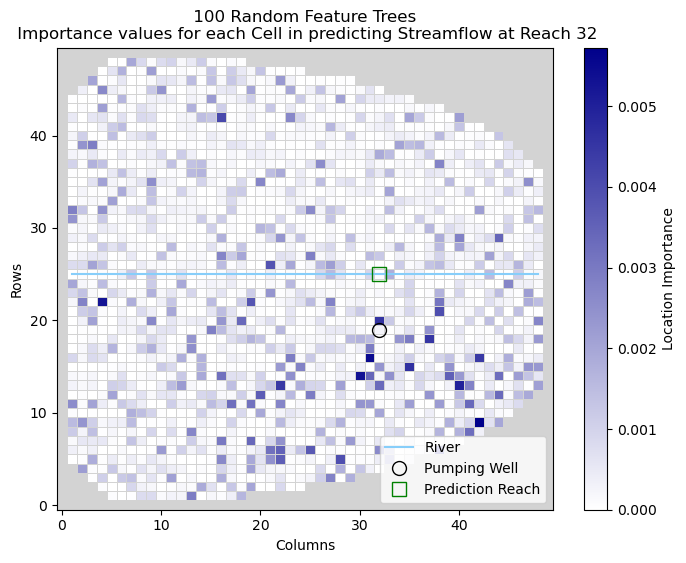

In [51]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

imp_df = pd.read_pickle('outputs/importance/SSTest12DrawCap_DT_Impdf.pkl')
imp_df_rand = pd.read_pickle('outputs/importance/SSTest12DrawCap_RFT_Impdf.pkl')

numTS = 1
n = 100

title = 'Decision Tree \n Importance values for each Cell in predicting Capture at Reach ' + str(rn)
wellmesh_df = plotImportance(imp_df,well_head_noRiv, well_loc_df,numTS,1,rn,title)
#axs[0] = plotImportance(imp_df,well_head_noRiv, well_loc_df,numTS,1,rn,title)

title_rand = ' 100 Random Feature Trees \n Importance values for each Cell in predicting Streamflow at Reach ' + str(rn)
wellmesh_rand = plotImportance(imp_df_rand,well_head_noRiv, well_loc_df,numTS,n,rn,title_rand)
#axs[1] = plotImportance(imp_df_rand,well_head_noRiv, well_loc_df,numTS,n,rn,title_rand)


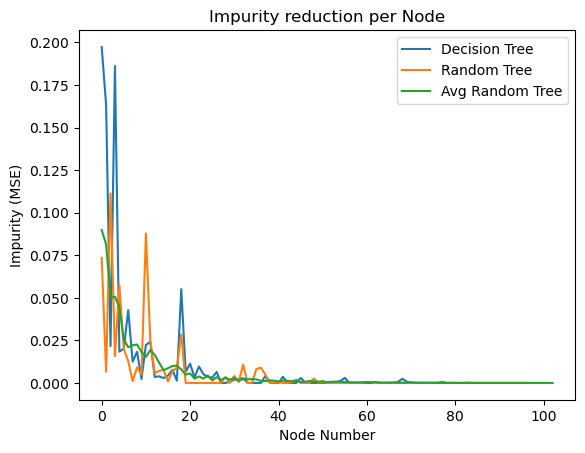

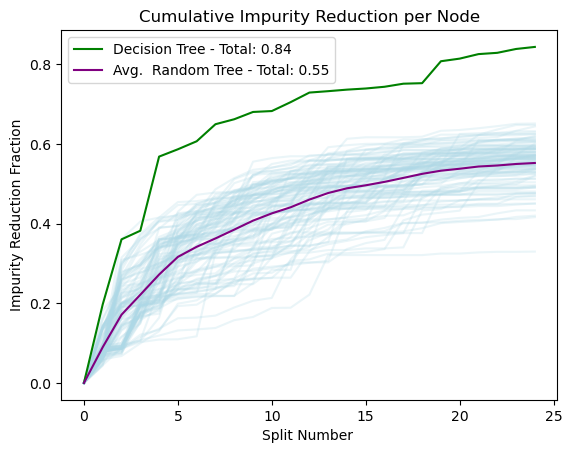

In [33]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import evalTree

impurity_df = pd.DataFrame(rand_impurity_list).fillna(0)
avg_rand_impurity = impurity_df.mean(axis = 0)

max_rand_idx = impurity_df.iloc[:,:2].sum(axis=1).idxmax()
#print(max_rand_idx)
#print(impurity_df)
max_rand_impurity = impurity_df.loc[max_rand_idx]

min_rand_idx = impurity_df.sum(axis = 1).idxmin()
min_rand_idx = impurity_df[0].idxmin()

min_rand_impurity = impurity_df.loc[min_rand_idx]
#display(impurity_df)
#print(Tree.max_features_)
#print(Tree.n_features_in_)
#print(sorted(randTree.feature_importances_, reverse=True)[:3])
#from treeFuncs import evalTree
rand_imp_improv = quickEvalTree(randTree)

plt.plot(imp_improv, label = "Decision Tree")
plt.plot(rand_imp_improv, label ="Random Tree")
plt.plot(avg_rand_impurity, label ="Avg Random Tree")
plt.title('Impurity reduction per Node')
plt.ylabel('Impurity (MSE)')
plt.xlabel('Node Number')
plt.legend()
#help(tree._tree.Tree)
plt.show()

#quick cumulative function that inserts 0 at beginning 
def cumImpurity(imp):
    nodes = 25
    return np.cumsum(np.insert(imp,0,0))[:nodes] #inserting 0 at the beginning - essentially to indicate the original impurity reduction (0)
   # return np.cumsum(imp)[:nodes]

dt_impurity_cumulative = cumImpurity(imp_improv)
#rand_impurity_cumulative = cumImpurity(rand_imp_improv)[:50]
avgrand_impurity_cumulative = cumImpurity(avg_rand_impurity.to_numpy())
maxrand_impurity_cumulative = cumImpurity(max_rand_impurity.to_numpy())
minrand_impurity_cumulative = cumImpurity(min_rand_impurity.to_numpy())
x_nodes = np.arange(len(minrand_impurity_cumulative))
          
for i in range(n):
    single_impurity = cumImpurity(impurity_df.loc[i].to_numpy())
    plt.plot(single_impurity, color='lightblue', alpha = 0.25)
    
plt.plot(dt_impurity_cumulative, markersize = 4, color='g', label = "Decision Tree - Total: {:.2f}".format(np.max(dt_impurity_cumulative)))
#plt.plot(rand_impurity_cumulative, markersize = 4, marker= 'o', label ="Random Tree - Total: {:.2f}".format(np.max(rand_impurity_cumulative)))
plt.plot(avgrand_impurity_cumulative, markersize = 4, color='purple', label ="Avg.  Random Tree - Total: {:.2f}".format(np.max(avgrand_impurity_cumulative)))
#plt.fill_between(x_nodes,maxrand_impurity_cumulative, minrand_impurity_cumulative, alpha = 0.2, label ="Min and Max Random Tree")
#plt.plot(maxrand_impurity_cumulative, markersize = 4,marker='.', label ="Max  Random Tree - Total: {:.2f}".format(np.max(avgrand_impurity_cumulative)))
    
plt.title('Cumulative Impurity Reduction per Node')
plt.ylabel('Impurity Reduction Fraction')
plt.xlabel('Split Number ')
plt.xticks(minor=True)
plt.legend()

## Gradient Boosting

In [34]:
#print(xgr_random.scorer_,xgr_random.best_score_)
best_pars_gr={'subsample':1.0,'n_estimators': 40, 'min_samples_split': 25, 'min_samples_leaf': 2, 'min_impurity_decrease': 100, 'max_leaf_nodes': 136, 'max_depth': 8, 'loss': 'squared_error', 'criterion': 'squared_error'}
#diff best pars
#best_pars_gr = {'subsample': 0.7, 'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_impurity_decrease': 5, 'max_leaf_nodes': None, 'max_depth': 5, 'loss': 'squared_error', 'learning_rate': 0.2, 'criterion': 'friedman_mse'}

Shape of Input Samples: (942, 2012)
Shape of Output Targets: (942,)
Total time: 157.88528728485107


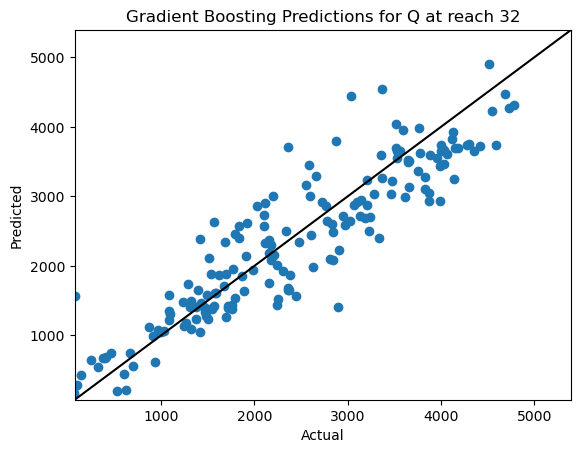

       bias        rmse        r       nse  lognse       kge
0 -2.025573  480.622459  0.93115  0.865356   0.733  0.883918


In [35]:
# Split dataset into training set and test set, default here is 30% test
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel

t0 = time.time()
n = 1
rn = 32

gr_imp_df, metrics_df_gr, impurity_gr, GB, y_test, y_pred_gb = trainAndEvaluateModel(GradientBoostingRegressor, well_head_noRiv, new_zone_q[rn], best_pars_gr, 0.2, n, random_state)  


t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

plt.figure()
plt.scatter(y_test, y_pred_gb)

outmax = np.max(y_pred_gb) *1.1
outmin = np.min(y_pred_gb) *0.75
plt.plot([outmin, outmax], [outmin, outmax], color='k', linestyle='-')

lim_tup = (outmin,outmax)
plt.ylim(lim_tup)
plt.xlim(lim_tup)


plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Gradient Boosting Predictions for Q at reach " + str(rn)
plt.title(title)

plt.show()
print(metrics_df_gr)

DecisionTreeRegressor(max_depth=8, max_leaf_nodes=136,
                      min_impurity_decrease=100, min_samples_leaf=2,
                      min_samples_split=25,
                      random_state=RandomState(MT19937) at 0x1372DA7CD40)


[Text(0.5, 0.8333333333333334, 'node #0\n(18, 32) <= 4.0\nsquared_error = 1479957.9\nsamples = 100.0%\nvalue = -0.0'),
 Text(0.25, 0.5, 'node #1\n(25, 25) <= 0.5\nsquared_error = 1235946.7\nsamples = 83.1%\nvalue = -243.4'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'node #2\n(25, 41) <= 0.0\nsquared_error = 951068.9\nsamples = 16.9%\nvalue = 1199.8'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

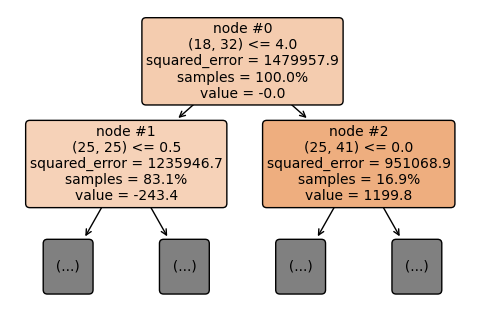

In [36]:
rootTree = GB.estimators_[0][0]
print(rootTree)

#evalTree(Tree)
plt.figure(figsize=((6,4)))
featurelocs = [tuple(i) for i in well_loc_df.loc[GB.feature_names_in_.astype(int)].to_numpy()] #well_loc_df.loc[topList].to_numpy()]
#print(featurenames)
tree.plot_tree(rootTree, max_depth=1, filled=True, proportion=True, fontsize=10, precision=1,rounded=True,node_ids = True,feature_names=featurelocs)

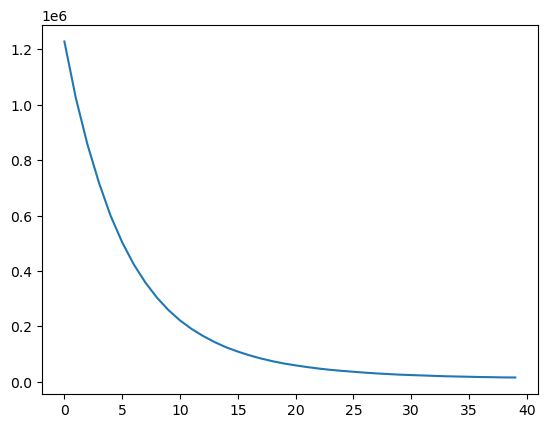

In [37]:
plt.plot(GB.train_score_)

In [98]:
#Save the importance DF for later
gr_imp_df.to_pickle('outputs/importance/SSTest12DrawCap_GB_Impdf.pkl')

C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("Blues")#,lut=20)


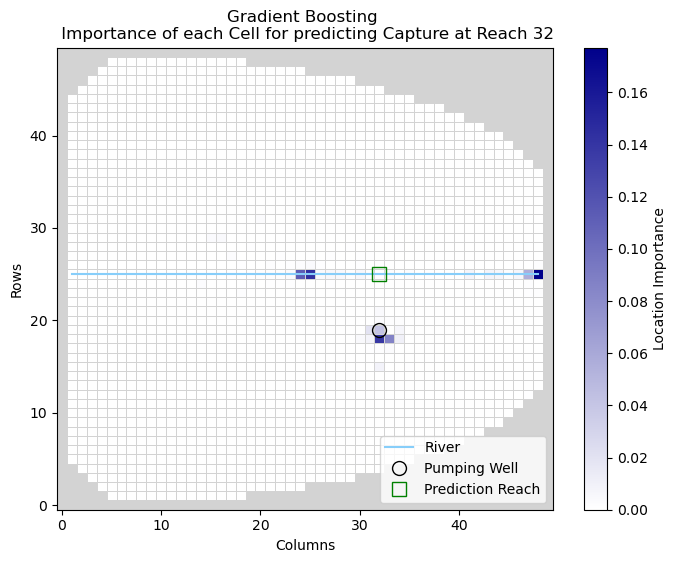

In [52]:
n=1
gr_imp_df = pd.read_pickle('outputs/importance/SSTest12DrawCap_GB_Impdf.pkl')
title_gr = 'Gradient Boosting \n Importance of each Cell for predicting Capture at Reach '+str(rn)
wellmesh_gr = plotImportance(gr_imp_df,well_head_noRiv, well_loc_df,1,n,rn,title_gr)

## Random Forest - Steady State

In [78]:
#new best RF
#Best Diff Pars
#best_pars_rf = {'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 5, 'max_samples': 0.9, 'max_leaf_nodes': None, 'max_depth': 7, 'criterion': 'friedman_mse'}
#Best pars used in transient scenario 

best_pars_rf = {'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 75, 'max_samples': 0.7, 'max_leaf_nodes': None, 'max_depth': 6, 'criterion': 'squared_error'}

In [91]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1
rn = 39
    
rf_imp_df, metrics_df_rf, impurity_list, Tree, y_test, y_pred_rf = trainAndEvaluateModel(RandomForestRegressor, well_head_noRiv, new_zone_q[rn], best_pars_rf, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

print(metrics_df_rf)

Shape of Input Samples: (942, 2012)
Shape of Output Targets: (942,)
Total time: 41.71305203437805
   bias   rmse    r  nse  lognse  kge
0 -1.53 764.55 0.92 0.84    0.69 0.83


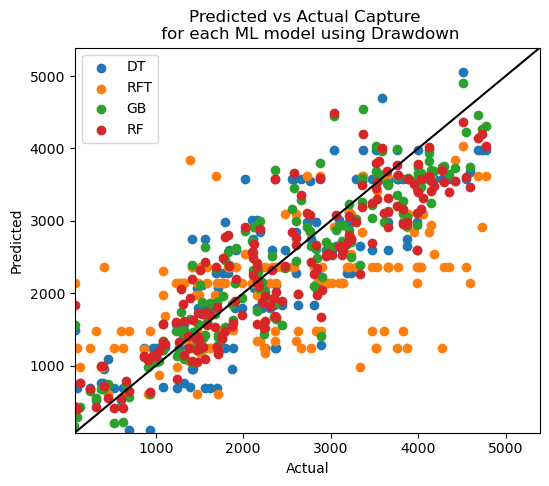

In [42]:
plt.figure(figsize=(6,5))
predList = [y_pred_dt,y_pred_rft,y_pred_gb,y_pred_rf]
labels = ['DT','RFT','GB','RF']
for i in range(4):
    plt.scatter(y_test, predList[i], label=labels[i])

plt.plot([outmin, outmax], [outmin, outmax], color='k', linestyle='-')

lim_tup = (outmin,outmax)
plt.ylim(lim_tup)
plt.xlim(lim_tup)

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Predicted vs Actual Capture \n for each ML model using Drawdown" 
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.show()

In [99]:
# #display(gr_imp_df)
# print(metrics_df_gr)
# MostImp = []
# for i in range(n):
#     MostImp.append(int(gr_imp_df[i].idxmax()))

# countlist = [MostImp.count(i) for i in MostImp]
# print(MostImp)
# #print(countlist)
# display(well_loc_df.loc[MostImp])

# oob_improvement = Tree.oob_prediction_

# plt.plot(oob_improvement)
# plt.title('Out of Bag improvement - Random Forest')
# plt.xlabel('Number of Estimators (Trees)')
# plt.ylabel('Variance')

In [30]:
#display(rf_imp_df)
MostImp = []
for i in range(n):
    MostImp.append(int(rf_imp_df[i].idxmax()))

countlist = [MostImp.count(i) for i in MostImp]
print(MostImp)
print(countlist)
display(well_loc_df.loc[MostImp])

[1149]
[1]


,0,1
1149,27,48


In [93]:
#Save the importance DF for later
#DrawCap20 is for reach 20 - no number indicates reach 32
rf_imp_df.to_pickle('outputs/importance/SSTest12DrawCap39_RF_Impdf.pkl')

C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("Blues")#,lut=20)


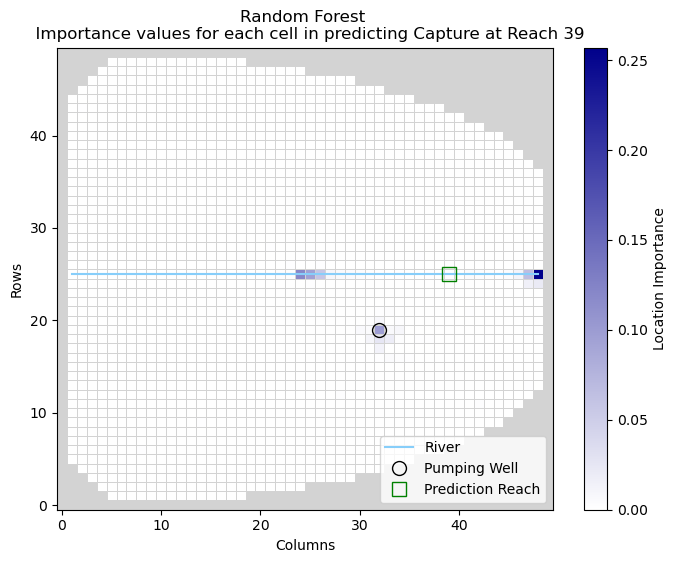

In [94]:
rf_imp_df = pd.read_pickle('outputs/importance/SSTest12DrawCap39_RF_Impdf.pkl')


title_rf = 'Random Forest \n  Importance values for each cell in predicting Capture at Reach ' + str(rn)
wellmesh_rf = plotImportance(rf_imp_df,well_head_noRiv, well_loc_df,numTS,1,rn,title_rf)
#plt.plot(20, 25, marker="*", markersize=16, color="Green", linestyle = "None",label="Prediction Reach")

# wellmesh_rf_32 = plotImportance(rf_imp_df_32,well_head_noRiv, well_loc_df,numTS,1,rn,title_rf)
# wellmesh_rf_37 = plotImportance(rf_imp_df_37,well_head_noRiv, well_loc_df,numTS,1,rn,title_rf)
#title_rf = 'Random Forest \n  Importance values for each cell in predicting flow at reach ' + str(20)
#wellmesh_rf_20 = plotImportance(rf_imp_df_37,well_head_noRiv, well_loc_df,numTS,1,20,title_rf)


### Testing the parameters as features
Using a single decision tree and the reach 32 out flow

In [47]:
t0 = time.time()
n = 1
pars = X.loc[well_head_noRiv.index]
imp_df_pars, metrics_df_pars, pars_impurity_list, parsTree, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, pars, new_zone_q[rn],None, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_pars.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Example Random Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)

NameError: name 'X' is not defined

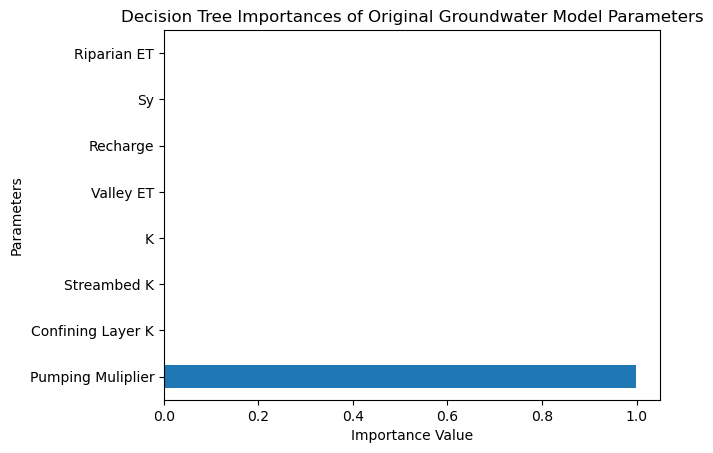

In [128]:
plot_par_names = ['K', 'Confining Layer K', 'Sy', 'Recharge', 'Valley ET', 'Riparian ET', 'Streambed K','Pumping Muliplier']
feat_importances = pd.Series(parsTree.feature_importances_, index=plot_par_names)
feat_importances.nlargest(10).plot(kind='barh',)
plt.xlabel('Importance Value')
plt.ylabel('Parameters')
plt.title('Decision Tree Importances of Original Groundwater Model Parameters')
plt.show()

In [129]:
#set up the meshgrid   
kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)


river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")
wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
for k in range(len(all_well_loc)):
        wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

cmap_rf = mp.colormaps.get_cmap("Greens")
wellmesh_rf_masked = np.ma.masked_array(wellmesh_rf, wellmesh_rf < 0.001)

cmap_gr = mp.colormaps.get_cmap("Purples")
wellmesh_gr_masked = np.ma.masked_array(wellmesh_rf_32, wellmesh_rf_32 < 0.001)

cmap_dt = mp.colormaps.get_cmap("Blues")
wellmesh_dt_masked = np.ma.masked_array(wellmesh_rf_37, wellmesh_rf_37 < 0.001)

cmap_rand = mp.colormaps.get_cmap("Reds")
wellmesh_rand_masked = np.ma.masked_array(wellmesh_rf_20, wellmesh_rf_20 < 0.01)

# combine them and build a new colormap
colors = np.vstack((cmap_rf(np.linspace(0.,1,128)), cmap_gr(np.linspace(0.,1,128)), cmap_dt(np.linspace(0.,1,128)),cmap_rand(np.linspace(0.,1,128))))
print(colors)
vmin= 0.001
vmax= 0.05
mymap = mp.colors.LinearSegmentedColormap.from_list('Merged',colors)
fig, axs = plt.subplots(figsize=(10,12))
#plt.figure(figsize=(8,10))
alpha = 0.6
axs.pcolormesh(KK,GG,wellmesh_bd,vmax = vmax, vmin = vmin, cmap = cmap_bd, shading='nearest', alpha = 0.05)
axs.pcolormesh(KK,GG,wellmesh_rand_masked,vmax = vmax, vmin = vmin, cmap = cmap_rand, shading='nearest', alpha = alpha)
axs.pcolormesh(KK,GG,wellmesh_dt_masked,vmax = vmax, vmin = vmin, cmap = cmap_dt, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Decision Tree", shrink = 0.25, pad = 0.05, anchor = (0,0.25), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rf_masked,vmax = vmax, vmin = vmin, cmap = cmap_rf, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Random Forest", shrink = 0.25, anchor = (0.3,0.75), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_gr_masked,vmax = vmax, vmin = vmin, cmap = cmap_gr, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Gradient Boosted", shrink = 0.25, anchor = (0.75,1), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rand_masked,vmax = vmax, vmin = vmin, cmap = cmap_rand, shading='nearest', alpha = alpha)

#plt.colorbar(cmap = mymap, location = 'bottom')


axs.plot(range(1,49),river, color="lightblue", label='River')
axs.plot(32, 21, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
axs.plot(25, 25, marker="*", markersize=10, color="Green", linestyle = "None",label="Prediction Reach")
axs.plot(32, 25, marker="*", markersize=10, color="Purple", linestyle = "None",label="Prediction Reach")
axs.plot(37, 25, marker="*", markersize=10, color="Blue", linestyle = "None",label="Prediction Reach")
axs.plot(20, 25, marker="*", markersize=10, color="Red", linestyle = "None",label="Prediction Reach")

axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Random Forest Importance values for each cell in predicting flow at reach ' + str(rn) + ' for 3 different target reaches ')
axs.legend(loc="lower right")
#axs[1].axis('off')
cbar = fig.colorbar(mp.cm.ScalarMappable(cmap=mymap), drawedges = False, ax = axs,label = 'Importance Gradients (darker = more important)', orientation = 'horizontal', ticks = [0,0.1,0.35,0.6,0.85,1],pad = 0.1, shrink = 0.75)
cbar.ax.set_xticklabels(['','Reach 20','Reach 25', 'Reach 32','Reach 37',''])
#plt.legend()

C:\Users\davem\AppData\Local\Temp\ipykernel_7236\2090807893.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_bd = cm.get_cmap("gray")#,lut=20)


NameError: name 'wellmesh_rf_32' is not defined

Number of locations used:  391
Number of locations used:  24
Number of locations used:  427
Number of locations used:  42


([<matplotlib.axis.XTick at 0x1373e687490>,
 [Text(0, 0, '0'),
  Text(50, 0, '50'),
  Text(100, 0, '100'),
  Text(150, 0, '150'),
  Text(200, 0, '200'),
  Text(250, 0, '250'),
  Text(300, 0, '300'),
  Text(350, 0, '350'),
  Text(400, 0, '400'),
  Text(450, 0, '450')])

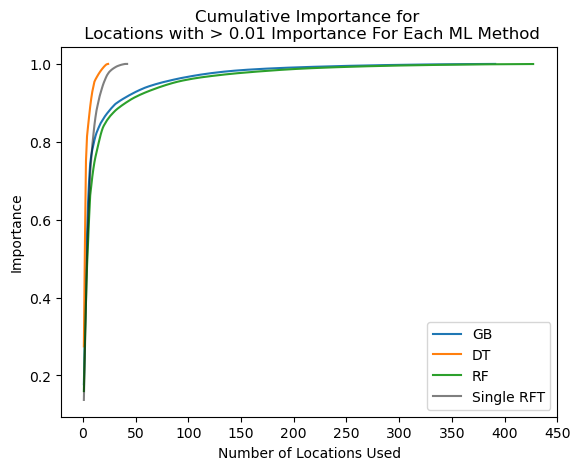

In [55]:
def nzLocImp(df):
    
    if isinstance(df, pd.Series):
        tempdf = df[df> 0.00001].sort_values(ascending=False).cumsum().dropna().reset_index(drop=True)
    else:
        tempdf = df[df> 0.00001].sort_values(ascending=False,by=df.columns[0]).cumsum().dropna().reset_index(drop=True)
   
    tempdf.index += 1    #set to 1 based index
    print("Number of locations used: ",len(tempdf))
    
    return tempdf


#print(nzLocImp(rf_imp_df))
plt.plot(nzLocImp(gr_imp_df), label='GB')
plt.plot(nzLocImp(imp_df), label = 'DT')
plt.plot(nzLocImp(rf_imp_df), label = 'RF')
#plt.plot(nzLocImp(imp_df_rand.sum(axis=1)/100), label = 'All RFT')

for i in range(1):
    plt.plot(nzLocImp(imp_df_rand[n]), alpha=0.5, color = 'k', label='Single RFT')
plt.xlabel('Number of Locations Used')
plt.ylabel('Importance')
plt.title('Cumulative Importance for \n Locations with > 0.01 Importance For Each ML Method')
plt.legend()
plt.xticks(range(0,500,50))
